In [145]:
import tensorflow as tf
from tensorflow import keras
tf.keras.__version__

'2.2.4-tf'

### Travis James Smith, Assignment 6

# Problem 2
A lot of this is taken from Chollet's 5.4 notebook. We're using the model we trained when running Chollet's 5.2 notebook (with 100 epochs).

In [146]:
from tensorflow.keras.models import load_model

model_chollet = load_model('cats_and_dogs_small_2.h5')
model_chollet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [147]:
img_path = 'tiger.jpg'

# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
print(type(img), img.size)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(type(img_tensor), img_tensor.size)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

<class 'PIL.JpegImagePlugin.JpegImageFile'> (150, 150)
<class 'numpy.ndarray'> 67500


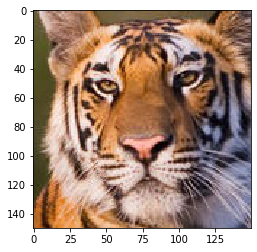

In [148]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [149]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_chollet.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = Model(inputs=model_chollet.input, outputs=layer_outputs)

In [150]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(activations)

[array([[[[0.02191459, 0.        , 0.        , ..., 0.0140293 ,
          0.        , 0.        ],
         [0.03691841, 0.        , 0.        , ..., 0.02530031,
          0.        , 0.        ],
         [0.07630204, 0.        , 0.        , ..., 0.02346359,
          0.        , 0.026432  ],
         ...,
         [0.        , 0.        , 0.01967156, ..., 0.03610188,
          0.        , 0.        ],
         [0.        , 0.        , 0.00040524, ..., 0.03459854,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.04001724,
          0.        , 0.        ]],

        [[0.02632063, 0.        , 0.        , ..., 0.00795867,
          0.        , 0.        ],
         [0.04488539, 0.        , 0.        , ..., 0.00971636,
          0.        , 0.        ],
         [0.09849556, 0.        , 0.        , ..., 0.00530992,
          0.        , 0.00398795],
         ...,
         [0.02035189, 0.        , 0.01565796, ..., 0.01399162,
          0.        , 0.

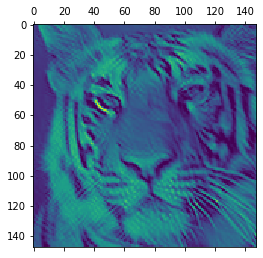

In [151]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

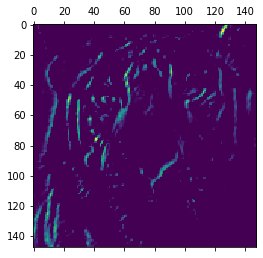

In [152]:
plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')
plt.show()

C:\Users\aoeuaoeu\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


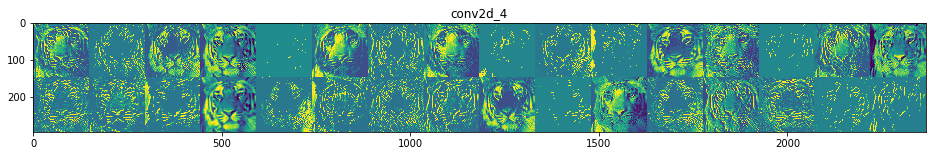

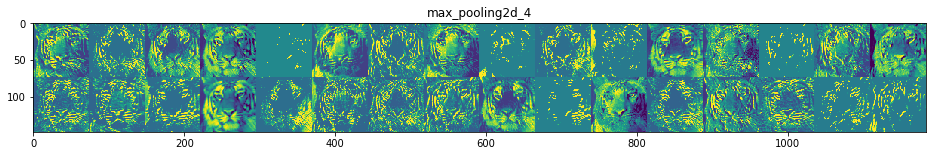

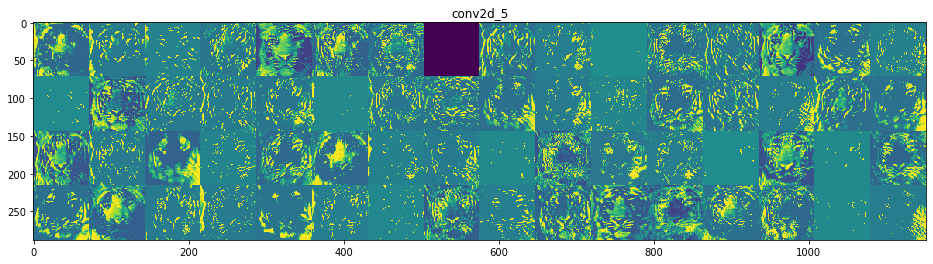

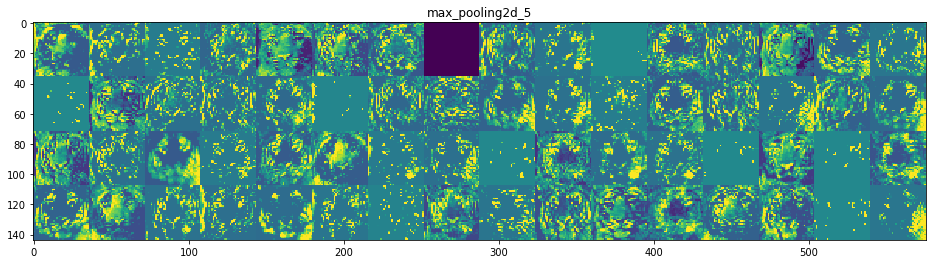

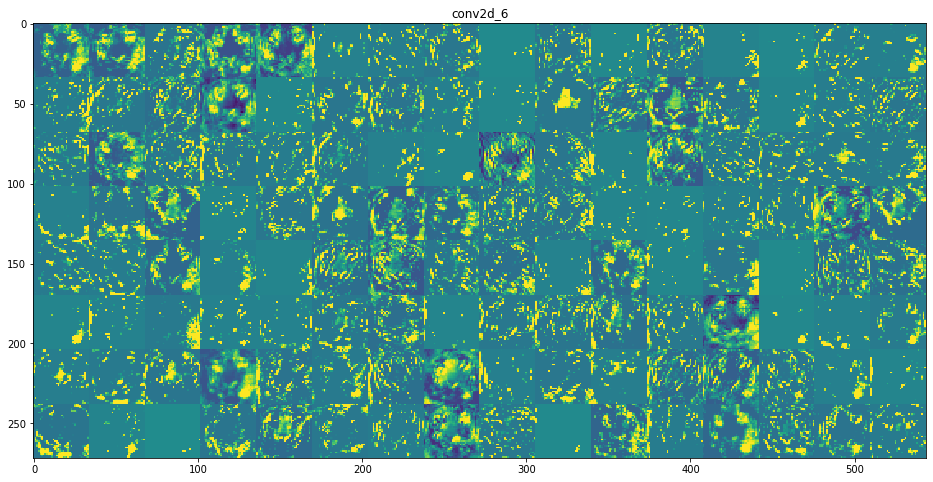

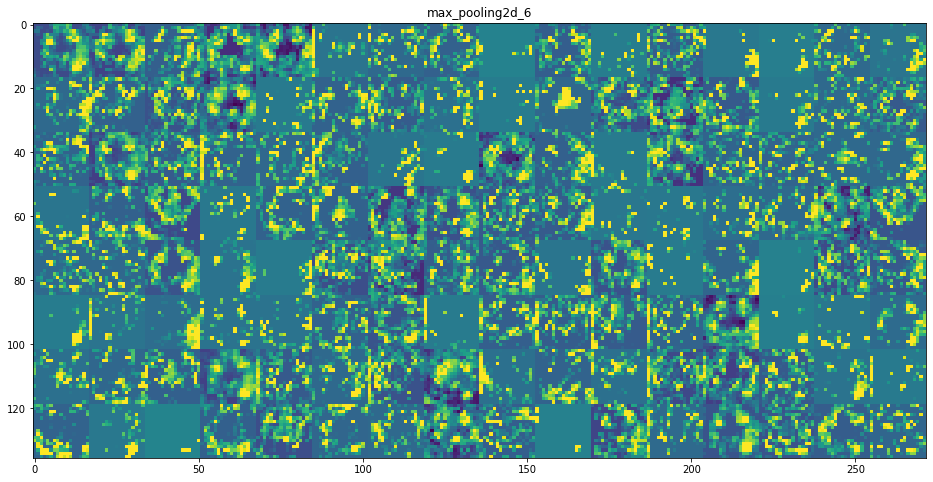

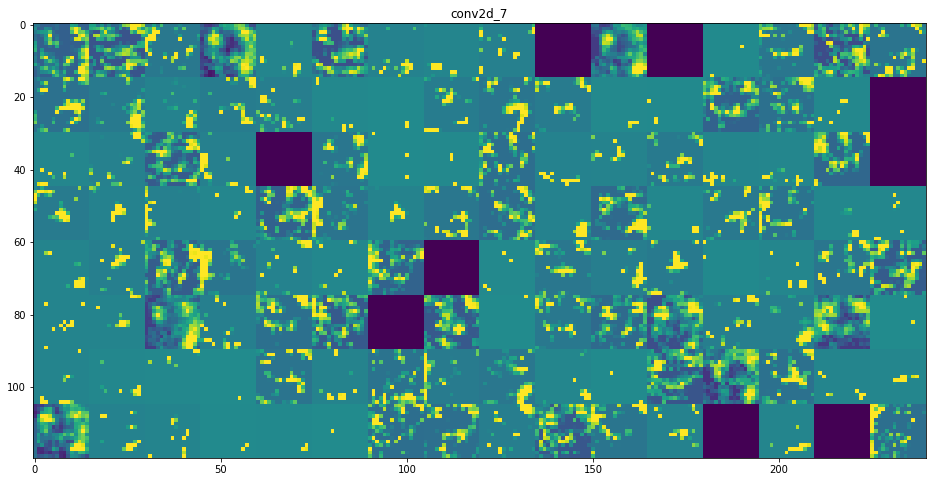

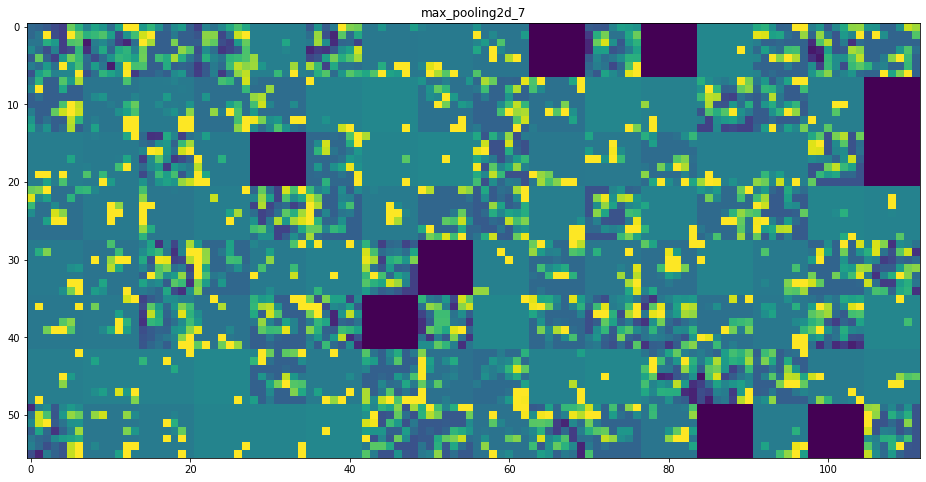

In [153]:
from tensorflow import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_chollet.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

I'll come back and trim this down if time permits, but the script from the Chollet notebook actually already allows us to view the activations for all the layers in the convnet. The third annd thirtieth filter activations for the first layer are visualized in the `cov2d_4` grid. You can see that things get more abstract over time, and that the pooling creates more compact representations deeper into the network.

# Problem 3
Copying our large CNN from the other notebook. Note that we're already using Keras with a Tensorflow backend based on our imports up top.

In [154]:
# Large CNN model for the CIFAR-10 Dataset
import numpy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD

In [155]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

model_p3 = load_model('cifar10.h5')

if not model_p3:
    # fix random seed for reproducibility
    seed = 7
    numpy.random.seed(seed)
    # load data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    # normalize inputs from 0-255 to 0.0-1.0
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    # one hot encode outputs
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    # Create the model
    model_p3 = tf.keras.Sequential()
    model_p3.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model_p3.add(Dropout(0.2))
    model_p3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model_p3.add(MaxPooling2D(pool_size=(2, 2)))
    model_p3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_p3.add(Dropout(0.2))
    model_p3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_p3.add(MaxPooling2D(pool_size=(2, 2)))
    model_p3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_p3.add(Dropout(0.2))
    model_p3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_p3.add(MaxPooling2D(pool_size=(2, 2)))
    model_p3.add(Flatten())
    model_p3.add(Dropout(0.2))
    model_p3.add(Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)))
    model_p3.add(Dropout(0.2))
    model_p3.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
    model_p3.add(Dropout(0.2))
    model_p3.add(Dense(num_classes, activation='softmax'))
    # Compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model_p3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
print(model_p3.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)       

In [156]:
if not model_p3:
    # Fit the model
    model_p3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)
    # Final evaluation of the model
    scores = model_p3.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

In [157]:
# Extracts the outputs of the top 8 layers:
layer_outputs_p3 = [layer.output for layer in model_p3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_p3 = Model(inputs=model_p3.input, outputs=layer_outputs_p3)

In [158]:
model_p3.save('cifar10.h5')

With the model trained and saved, let's try predicting our truck image (it works very well).

In [159]:
# Load the image
img = image.load_img("truck.jpg", target_size=(32, 32))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

activations_p3 = activation_model_p3.predict(img_tensor)
print(activations_p3)

[array([[[[4.50066030e-01, 0.00000000e+00, 7.99868703e-01, ...,
          2.65450239e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.21086150e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.73562515e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.66349101e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          5.05289793e-01, 0.00000000e+00, 0.00000000e+00]],

        [[8.69798958e-01, 0.00000000e+00, 1.48097801e+00, ...,
          4.20061022e-01, 5.32363057e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.19872779e-01, ...,
          4.04151618e-01, 3.33344907e-01, 0.00000000e+00],
       

Now let's run Chollet's code from Problem 2 to show our activation layers:

C:\Users\aoeuaoeu\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


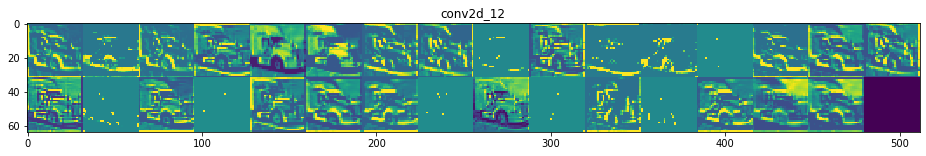

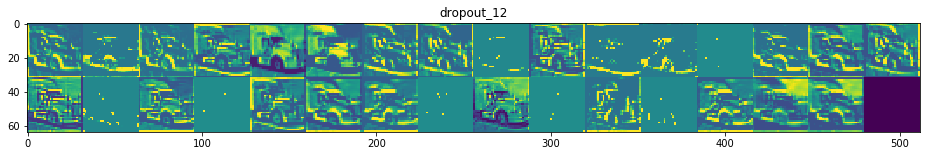

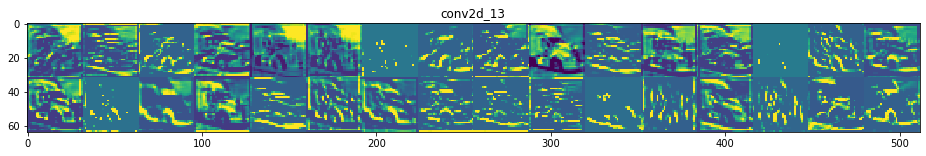

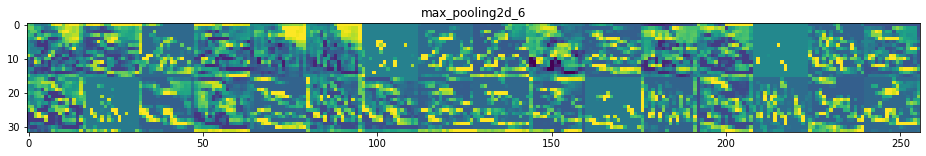

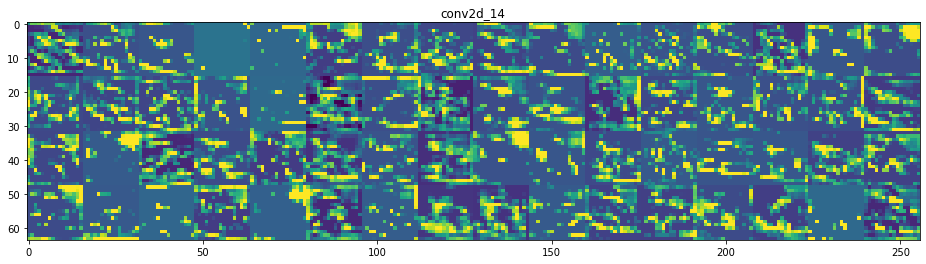

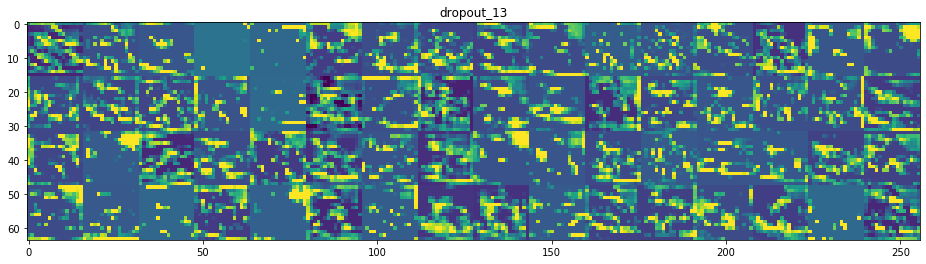

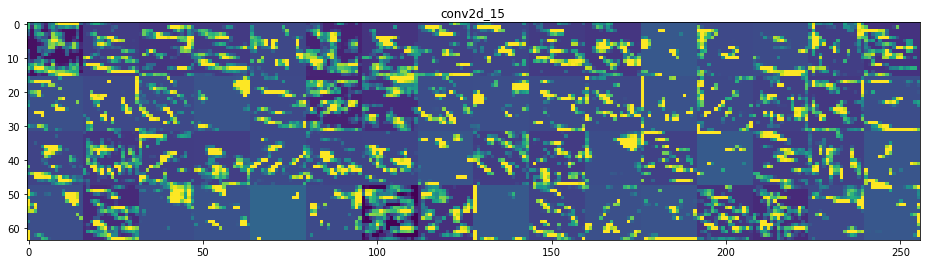

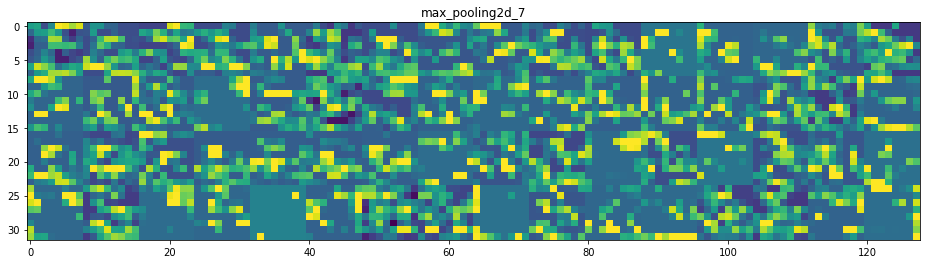

In [160]:
from tensorflow import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_p3.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_p3):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

This covnet still abstracts pretty thoroughly, but the image size is so much smaller that it doesn't seem to abstract quite as far away from the original image. We still end up with blobs, but they're closer in resolution to the original image.

# Problem 4

For this problem, it looks like we're going to take our pretrained VGG16 and verify that we can generate images that maximally activate its filters.

Then we're going to try the same thing with the model we trained in Problem 3 above. Let's see what happens, starting with VGG16 (which should look more or less like Chollet's notebook):

In [161]:
# Provided in our assignment notes
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [162]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model_p4 = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model_p4.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [163]:
grads = K.gradients(loss, model_p4.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [164]:
iterate = K.function([model_p4.input], [loss, grads])

In [165]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1. 
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [166]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [167]:
def generate_pattern(model, layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

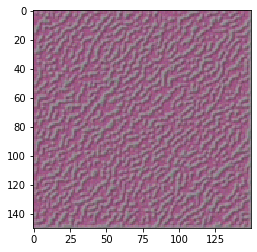

In [168]:
plt.imshow(generate_pattern(model_p4, 'block1_conv1',23))
plt.show()

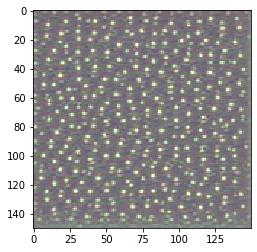

In [169]:
plt.imshow(generate_pattern(model_p4, 'block3_conv1', 0))
plt.show()

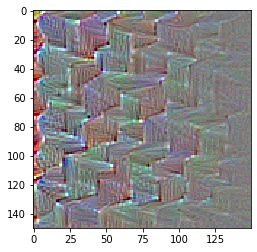

In [170]:
plt.imshow(generate_pattern(model_p4, 'block4_conv2', 5))
plt.show()

I didn't run this for all the layers. It felt unnecessary because, unsurprisingly, the code we took from Chollet's notebook works as advertised. Now let's try it on our model from Problem 3.

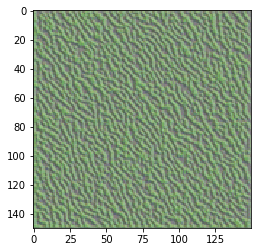

In [171]:
plt.imshow(generate_pattern(model_p3, 'conv2d_12', 0))
plt.show()

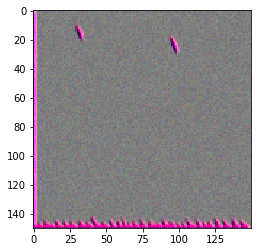

In [172]:
plt.imshow(generate_pattern(model_p3, 'conv2d_12', 2))
plt.show()

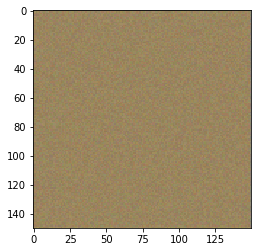

In [173]:
plt.imshow(generate_pattern(model_p3, 'conv2d_12', 5))
plt.show()

I just picked a few filters from the first and last conv layer at random (first above, last below). You can see that the filters deeper in the network appear to be more localized and abstracted, which fits our mental model of how they work.

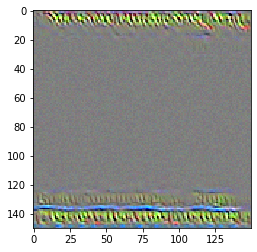

In [174]:
plt.imshow(generate_pattern(model_p3, 'conv2d_16', 70))
plt.show()

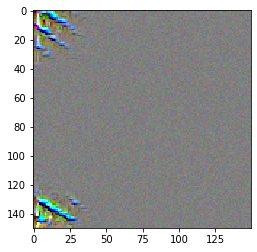

In [175]:
plt.imshow(generate_pattern(model_p3, 'conv2d_16', 127))
plt.show()

# Problem 5
Like above, we'll do this with VGG16, using code from the Chollet notebook, then we'll try using our CIFAR10 model from Problem 3. Note that I'm pulling out Chollet's comments.

In [176]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

model_p5 = VGG16(weights='imagenet')
print(model_p5.output)

Tensor("predictions_2/Softmax:0", shape=(None, 1000), dtype=float32)


In [177]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'bird.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [178]:
preds_p5 = model_p5.predict(x)
print('Predicted:', decode_predictions(preds_p5, top=3)[0])

Predicted: [('n01537544', 'indigo_bunting', 0.9999856), ('n02017213', 'European_gallinule', 1.2522398e-05), ('n01828970', 'bee_eater', 5.335672e-07)]


Very interestingly, VGG has an output for the exact species of bird in our image, and it's very, very confident in its prediction (I think maybe this particular image was in the training set, but I just found it on Google).

In [179]:
indigo_bunting_output = model_p5.output[:, 14]

last_conv_layer = model_p5.get_layer('block5_conv3')

grads = K.gradients(indigo_bunting_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model_p5.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
print(heatmap)

[[ 6.28662011e-10  2.95416996e-10  5.07912934e-10  6.79325707e-10
   1.13495657e-09  1.38846634e-09  1.08512710e-09  1.22185095e-09
   1.36062128e-09  6.15200668e-10  5.28539212e-10  9.74016645e-10
   8.94158525e-10  8.46438808e-10]
 [ 8.19878332e-11  8.58019697e-11  2.23234625e-10  3.76312703e-10
   4.87952012e-10  3.36671607e-10  1.29095512e-09  3.76215592e-09
   5.28499955e-09  3.22138183e-09  1.03860498e-09  3.09882592e-10
   3.48846840e-10  3.42457146e-10]
 [ 3.88512056e-10  1.87479324e-10  3.97473443e-10  5.34316813e-10
   5.50129386e-10  9.34549438e-10  2.85185497e-09  7.74365905e-09
   1.02412141e-08  6.63404354e-09  1.81217930e-09  1.43798407e-09
   9.10386655e-10  7.90323418e-10]
 [ 3.70095316e-10  2.72300210e-10  4.48144494e-10  4.91138352e-10
   4.50861459e-10  9.69202829e-10  3.36269546e-09  9.57423918e-09
   1.26724409e-08  8.62808136e-09  2.11368367e-09  2.08122319e-09
   1.16192378e-09  1.24890320e-09]
 [ 3.70496328e-10  3.80855014e-10  5.04833453e-10  5.01510167e-10
  

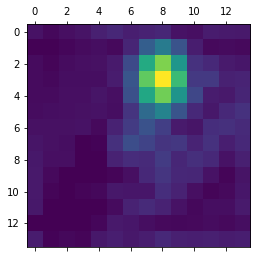

In [180]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [181]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('bird_cam.jpg', superimposed_img)

True

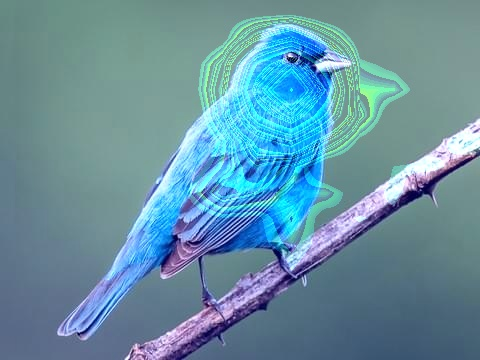

We get a heatmap that makes perfect sense, given our original image. The VGG covnet is targeting the most detail-rich, distinctive features of the bird in the image.

Presumably, with our CIFAR10 model, the heatmap will be less specific (since it will be taking into account all birds and not just this species). Let's try it.

(32, 32)


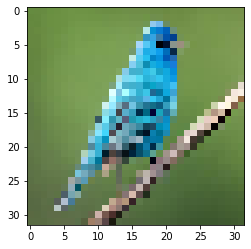

In [182]:
img = image.load_img(img_path, target_size=(32, 32))
print(img.size)
x_p3 = image.img_to_array(img)
x_p3 = np.expand_dims(x_p3, axis=0)
x_p3 = preprocess_input(x_p3)

# Checking that the scaling worked
plt.imshow(img)
plt.show()

In [183]:
preds_p3 = model_p3.predict(x_p3)
print(preds_p3)
print(model_p3.output)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Tensor("dense_8_1/Softmax:0", shape=(None, 10), dtype=float32)


In [188]:
bird_output = model_p3.output[:, 2]

last_conv_layer = model_p3.get_layer('conv2d_17')

grads = K.gradients(bird_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model_p3.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x_p3])

for i in range(32):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
print(heatmap)

[[ 0.4720439  1.3969877  1.7608469  3.1415315  5.828382   3.2924228
   4.231866   4.3918905]
 [ 0.8029547  1.9717605  3.078545   2.1173441  4.7217555  4.249811
   4.075338  10.026438 ]
 [ 0.8801541  3.7655637  3.5058448  8.169367   9.264082  10.663326
  13.441763  11.406592 ]
 [ 1.6973377  5.300047   7.666036  12.767144  13.768248  19.42057
  13.262924   9.064085 ]
 [ 3.4249713  7.272494  10.487307  15.1411705 15.8970785 16.365248
  12.84577   13.866613 ]
 [ 6.8395443  6.397132   6.640633   7.838963   7.90482   10.396034
  15.3190365 15.253327 ]
 [ 9.351826   8.603836   9.151899   9.123175   5.5149336  6.6826563
   7.601055   5.2382073]
 [ 7.9957004  7.892582   7.834955   6.4738684  6.1897373  6.0626574
   1.7955495  2.3650565]]


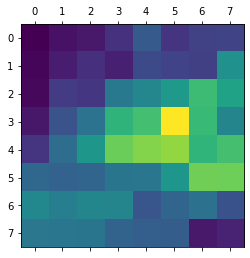

In [189]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [190]:
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('bird_cam_2.jpg', superimposed_img)

True

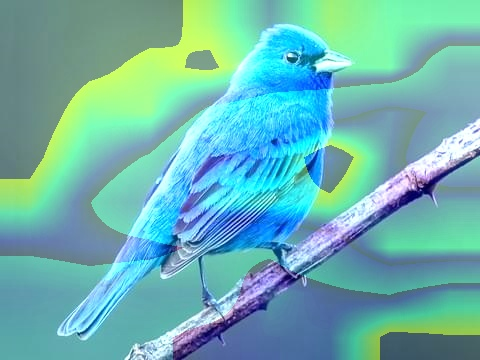

This result kind of makes sense -- first of all, it doesn't seem like we got the right classification to begin with. Our CIFAR10 model seems to think this is an image of a frog. Secondly, since we downscaled the image to 32x32, scaling it back up to superimpose the heatmap looks a little strange.